In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 1. Dataset

In [2]:
mean = 3.0 # Gaussian distribution의 mean
std = 2.4  # Gaussian distribution의 standard deviation
N = 10000 # 샘플링 횟수

# Gaussian distribution에서 N번 샘플링
X = np.random.normal(loc=mean, scale=std, size=N)
print(X)

[4.08725153 5.35037692 2.32906803 ... 3.6712251  1.04533907 8.66884088]


## 2. Optimization (Finding Parameters)

### - In Closed Form

$\mu_{ML} = {1 \over N} \sum_{n=1}^N x_n$

$\sigma^2_{ML}={1 \over N} \sum_{n=1}^N (x_n-\mu_{ML})^2$

In [3]:
mu_ML = np.mean(X)
std_ML = np.std(X)
print('Predicted mean :', mu_ML);
print('Predicted standard deviation :', std_ML)

Predicted mean : 3.0075549676489617
Predicted standard deviation : 2.376816592299426


### - By Optimizer
$\log p(X|\mu,\sigma^2)=-{N \over 2}\log 2\pi-{N \over 2}\log \sigma^2 -{1 \over {2\sigma^2}}\sum_{n=1}^N (x_n-\mu)^2$

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # shape (1), mean of the Gaussian distribution
        self.mean = nn.Parameter(torch.randn(1))
        
        # shape (1), log-standard deviation of the Gaussian distribution
        self.logstd = nn.Parameter(torch.randn(1))
        
    def _get_negative_log_likelihood(self, mean, logstd, X, eps=1e-5):
        # X : (batch)
        
        # sample 하나 당 평균 negative log-likelihood 계산
        return torch.mean(0.5 * np.log(2*np.pi) + logstd + 0.5 * (X - mean) ** 2 / (logstd.exp() ** 2))
        
    def forward(self, X):
        # X : (batch), a batch data
        
        negative_log_likelihood = self._get_negative_log_likelihood(self.mean, self.logstd, X)
        
        return negative_log_likelihood
        

## 3. Create Model and Optimizer

In [5]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

print('Model and Optimizer Created')

Model and Optimizer Created


## 4. Create data tensor

In [6]:
X_tensor = torch.from_numpy(X)
print(X_tensor)

tensor([4.0873, 5.3504, 2.3291,  ..., 3.6712, 1.0453, 8.6688],
       dtype=torch.float64)


## 5. Train Loop

In [7]:
# model을 train mode로 설정
model.train()

loss_list = []
param_list = []
for _ in range(10000):
    
    # model의 gradient들을 모두 0으로 설정
    model.zero_grad()
    
    # model의 forward function을 실행
    loss = model(X_tensor)
    loss_list.append(loss.item())

    # loss값을 시작으로 back-propagation 실행하여 gradient update
    loss.backward()
    # update된 gradient를 weight에 적용
    optimizer.step()
    
    param_list.append((model.mean.item(), model.logstd.item()))

param_list = np.array(param_list)
print('Train Finished')

Train Finished


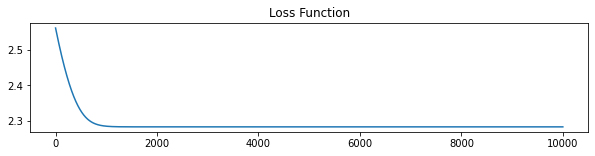

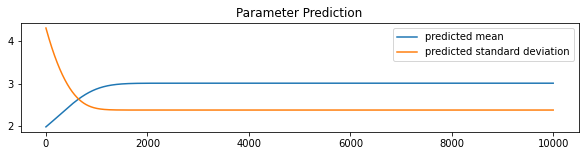

predicted mean : 3.007554769515991
predicted std : 2.3768168025108656


In [8]:
plt.figure(figsize=[10, 2])
plt.title('Loss Function')
plt.plot(loss_list)
plt.show()

plt.figure(figsize=[10, 2])
plt.title('Parameter Prediction')
plt.plot(param_list[:, 0], label='predicted mean')
plt.plot(np.exp(param_list[:, 1]), label='predicted standard deviation')
plt.legend()
plt.show()

print('predicted mean :', param_list[-1, 0])
print('predicted std :', np.exp(param_list[-1, 1]))